# Normalizing the Gamma Background (vz1)

#### Din-Ammar Tolj - Y25
Maruyama Group, Summer 2023

This notebook is a supplement/continuation of "SemaringProject_MuonsAndGammaSim_Din_vz5" Here, a TFractionFitter object is implemented which is able to weigh the linearly smeared gamma lines to minimize chi2/ndf.

### Import needed libraries

In [1]:
import os
import sys
import numpy as np
import ctypes
from ctypes import *
from ROOT import *
import ROOT
from root_numpy import array2hist, hist2array, fill_hist
import warnings
warnings.filterwarnings("ignore")
sys.path.append('libs/')
from dt5202 import dt5202_crunch # Import parser that Tom wrote. This is containted in the file named dt5202.py in this folder.
from dt5202oldDAQ import dt5202_crunch as dt5202_crunch_oldDAQ # Old ver

Welcome to JupyROOT 6.22/00


### Declare constants, static variables

In [2]:
# Declare constants for conversion from ADC to PE/MeV
adc_mev = 538.3933387436877 # from "MuonPeakCalibration_Din_ThanksEmily_v1_cut.ipynb"
pe_mev = 53.95 # gotten from averaging two values from "OLD_MuonsAndGammas_SimulationFitting_Din_v2_w_Caesium.ipynb"
ped = 50 #pedestal correction

sig662 = 0.159223 # Get the sigma in MeV from "Cs137_GaussFitting_ForResolution_Din_vz1.ipynb"
# sigma_pe = sigma * pe_mev # Convert to PE

sig1pe = (.662*pe_mev) / (sig662*pe_mev) 

R = 0.07
# gbins = 100 #Bins for each of the gamma lines
gmin = 0.01
gmax = 14
gbins = int((gmax-gmin)/R)

In [3]:
# Declare some static variables; simulated gamma lines
h_sim1 = TH1F('sim1', '', gbins, gmin, gmax)
h_sim2 = TH1F('sim2', '', gbins, gmin, gmax)
h_sim3 = TH1F('sim3', '', gbins, gmin, gmax)
h_sim4 = TH1F('sim4', '', gbins, gmin, gmax)
h_sim5 = TH1F('sim5', '', gbins, gmin, gmax)
h_sim6 = TH1F('sim6', '', gbins, gmin, gmax)
h_sim7 = TH1F('sim7', '', gbins, gmin, gmax)
h_sim8 = TH1F('sim8', '', gbins, gmin, gmax)
h_sim9 = TH1F('sim9', '', gbins, gmin, gmax)
h_sim10 = TH1F('sim10', '', gbins, gmin, gmax)
h_dat = TH1F('lab', '', gbins, gmin, gmax) #Lab data
tot = TH1F('tot','',gbins,gmin,gmax) 

# Smeared gamma lines
h_sme1 = TH1F('smear1', '', gbins, gmin, gmax)
h_sme2 = TH1F('smear2', '', gbins, gmin, gmax)
h_sme3 = TH1F('smear3', '', gbins, gmin, gmax)
h_sme4 = TH1F('smear4', '', gbins, gmin, gmax)
h_sme5 = TH1F('smear5', '', gbins, gmin, gmax)
h_sme6 = TH1F('smear6', '', gbins, gmin, gmax)
h_sme7 = TH1F('smear7', '', gbins, gmin, gmax)
h_sme8 = TH1F('smear8', '', gbins, gmin, gmax)
h_sme9 = TH1F('smear9', '', gbins, gmin, gmax)
h_sme10 = TH1F('smear10', '', gbins, gmin, gmax)
tots = TH1F('tots','',gbins,gmin,gmax)

### Import data (*NOTE: placeholder, want to turn this into a .py class*)

In [4]:
#Import simulated .ROOT files
folder_g = "gamma_sim/gamma_sim-build/" # location of the gamma sim build folder

# Open ROOT files
f1460 = TFile.Open(folder_g + "K40-1460KeV-25x.root","READ")
f2614 = TFile.Open(folder_g + "Tl208-2614KeV-25x.root","READ")

# Bismuth peaks
f1120 = TFile.Open(folder_g + "Bi214-1120KeV-25x.root", "READ")
f1238 = TFile.Open(folder_g + "Bi214-1238KeV-25x.root", "READ")
f1764 = TFile.Open(folder_g + "Bi214-1764KeV-25x.root", "READ")
f2204 = TFile.Open(folder_g + "Bi214-2204KeV-25x.root", "READ")
f609 = TFile.Open(folder_g + "Bi214-609KeV-25x.root", "READ")

# Lower energy peaks
f968 = TFile.Open(folder_g + "Ac228-968KeV-25x.root", "READ")
f934 = TFile.Open(folder_g + "Bi214-934KeV-25x.root", "READ")
f911 = TFile.Open(folder_g + "Ac228-911KeV-25x.root", "READ")
f583 = TFile.Open(folder_g + "Tl208-583KeV-25x.root", "READ")

## 

# Read the TTree for main two gamma isotopes
tree1460 = f1460.Get("Hits")
tree2614 = f2614.Get("Hits")

# Read the TTree for the nearby Bismuth-214 isotopes
tree1120 = f1120.Get("Hits")
tree1238 = f1238.Get("Hits")
tree1764 = f1764.Get("Hits")
tree2204 = f2204.Get("Hits")

# Read the TTree for the remaining low-freq. isotopes
tree968 = f968.Get("Hits")
tree934 = f934.Get("Hits")
tree911 = f911.Get("Hits")
tree609 = f609.Get("Hits")
tree583 = f583.Get("Hits")

# Append the energy values from the TTree into an array
energyDeposited1460 = []
entries= tree1460.GetEntries();
for i in range(0,entries):
    tree1460.GetEntry(i)
    energyDeposited1460.append(tree1460.EnergyDeposited)

energyDeposited2614 = []
entries= tree2614.GetEntries();
for i in range(0,entries):
    tree2614.GetEntry(i)
    energyDeposited2614.append(tree2614.EnergyDeposited)

energyDeposited1120 = []
entries= tree1120.GetEntries();
for i in range(0,entries):
    tree1120.GetEntry(i)
    energyDeposited1120.append(tree1120.EnergyDeposited)

energyDeposited1238 = []
entries= tree1238.GetEntries();
for i in range(0,entries):
    tree1238.GetEntry(i)
    energyDeposited1238.append(tree1238.EnergyDeposited)

energyDeposited1764 = []
entries= tree1764.GetEntries();
for i in range(0,entries):
    tree1764.GetEntry(i)
    energyDeposited1764.append(tree1764.EnergyDeposited)

energyDeposited2204 = []
entries= tree2204.GetEntries();
for i in range(0,entries):
    tree2204.GetEntry(i)
    energyDeposited2204.append(tree2204.EnergyDeposited)

energyDeposited968 = []
entries= tree968.GetEntries();
for i in range(0,entries):
    tree968.GetEntry(i)
    energyDeposited968.append(tree968.EnergyDeposited)

energyDeposited934 = []
entries= tree934.GetEntries();
for i in range(0,entries):
    tree934.GetEntry(i)
    energyDeposited934.append(tree934.EnergyDeposited)

energyDeposited911 = []
entries= tree911.GetEntries();
for i in range(0,entries):
    tree911.GetEntry(i)
    energyDeposited911.append(tree911.EnergyDeposited)

energyDeposited609 = []
entries= tree609.GetEntries();
for i in range(0,entries):
    tree609.GetEntry(i)
    energyDeposited609.append(tree609.EnergyDeposited)

energyDeposited583 = []
entries= tree583.GetEntries();
for i in range(0,entries):
    tree583.GetEntry(i)
    energyDeposited583.append(tree583.EnergyDeposited)


# Fill declared simulation histograms with data.
# smear1 = np.random.normal(loc=np.multiply(energyDeposited1460, pe_mev), scale = 0.01 * lin_sigma_pe * np.multiply(energyDeposited1460, pe_mev)) / pe_mev
fill_hist(h_sim1, energyDeposited1460)
fill_hist(h_sim2, energyDeposited2614)
fill_hist(h_sim3, energyDeposited1120)
fill_hist(h_sim4, energyDeposited1238)
fill_hist(h_sim5, energyDeposited1764)
fill_hist(h_sim6, energyDeposited968)
fill_hist(h_sim7, energyDeposited934)
fill_hist(h_sim8, energyDeposited911)
fill_hist(h_sim9, energyDeposited609)
fill_hist(h_sim10, energyDeposited583)

#Read and load lab data from directory
sourceFolder = "/data/board1771_01192023_retestingSwirlyPanel/"
onlyfiles = [f for f in os.listdir(sourceFolder) if '.dat' in f]
data_list = []
for file in onlyfiles:
    data_list.append(dt5202_crunch(str(sourceFolder)+str(file), num_ev=100000000, num_ch=1))
data = data_list[0]
for i in range(1, len(data_list)):
    data = np.append(data, data_list[i])

# Convert lab data to MeV
d = data['data']['low_gain']-ped
lab_mev = (d.astype('float64'))/adc_mev # lab data in MeV
fill_hist(h_dat, lab_mev)

[(259, [3, 0, 3], 1, 0, 288, 0.5, 1674156932637)]
((33, 0, 1.67415693e+09, 0, 1), (0, 3, 7938, 8051))
[(259, [3, 0, 3], 1, 0, 288, 0.5, 1674157533007)]
((33, 0, 1.67415753e+09, 0, 1), (0, 3, 1110, 8051))


### Apply linear smearing as done in SmearingProject notebook

In [5]:
h_sme1.Reset()
h_sme2.Reset()
h_sme3.Reset()
h_sme4.Reset()
h_sme5.Reset()
h_sme6.Reset()
h_sme7.Reset()
h_sme8.Reset()
h_sme9.Reset()
h_sme10.Reset()

fill_hist(h_sme1, np.random.normal(loc=np.array(energyDeposited1460) * pe_mev, scale = 0.7087 * np.power(sig1pe * np.array(energyDeposited1460) * pe_mev, 0.5))/pe_mev)
fill_hist(h_sme2, np.random.normal(loc=np.array(energyDeposited2614) * pe_mev, scale = 0.7087 * np.power(sig1pe * np.array(energyDeposited2614) * pe_mev, 0.5))/pe_mev)
fill_hist(h_sme3, np.random.normal(loc=np.array(energyDeposited1120) * pe_mev, scale = 0.7087 * np.power(sig1pe * np.array(energyDeposited1120) * pe_mev, 0.5))/pe_mev)
fill_hist(h_sme4, np.random.normal(loc=np.array(energyDeposited1238) * pe_mev, scale = 0.7087 * np.power(sig1pe * np.array(energyDeposited1238) * pe_mev, 0.5))/pe_mev)
fill_hist(h_sme5, np.random.normal(loc=np.array(energyDeposited1764) * pe_mev, scale = 0.7087 * np.power(sig1pe * np.array(energyDeposited1764) * pe_mev, 0.5))/pe_mev)
fill_hist(h_sme6, np.random.normal(loc=np.array(energyDeposited968) * pe_mev, scale = 0.7087 * np.power(sig1pe * np.array(energyDeposited968) * pe_mev, 0.5))/pe_mev)
fill_hist(h_sme7, np.random.normal(loc=np.array(energyDeposited934) * pe_mev, scale = 0.7087 * np.power(sig1pe * np.array(energyDeposited934) * pe_mev, 0.5))/pe_mev)
fill_hist(h_sme8, np.random.normal(loc=np.array(energyDeposited911) * pe_mev, scale = 0.7087 * np.power(sig1pe * np.array(energyDeposited911) * pe_mev, 0.5))/pe_mev)
fill_hist(h_sme9, np.random.normal(loc=np.array(energyDeposited609) * pe_mev, scale = 0.7087 * np.power(sig1pe * np.array(energyDeposited609) * pe_mev, 0.5))/pe_mev)
fill_hist(h_sme10, np.random.normal(loc=np.array(energyDeposited583) * pe_mev, scale = 0.7087 * np.power(sig1pe * np.array(energyDeposited583) * pe_mev, 0.5))/pe_mev)

In [6]:
# REDO the entire TFractionFitter shenanigans

gStyle.SetOptStat("")
gStyle.SetOptFit(0)

gStyle.SetPadBottomMargin(0.12)
gStyle.SetPadLeftMargin  (0.11)
#gStyle.SetPadTopMargin   (0.02)
gStyle.SetPadRightMargin (0.05)

gStyle.SetTitleOffset(1.2,"x")
gStyle.SetTitleOffset(1.0,"y")
gStyle.SetTitleSize(0.045,"xy")
gStyle.SetLabelSize(0.040,"xy")

h_dat.Sumw2()

# pre-scale the MC histos so the templates have similar error
# this helps the fitter give same weight to all MC
# so it's independant of MC statistics
# but if statistics are too low, it won't work
lx = int(0.3/R)
ux = int(2.6/R)
dat_int = h_dat.Integral(lx,ux)
int1 = h_sme1.Integral(lx,ux)
h_sme1.Scale(dat_int/int1)
h_sme1.Sumw2()
int2 = h_sme2.Integral(lx,ux)
h_sme2.Scale(dat_int/int2)
#h_sim2.Scale(dat_int/int2 * 0.199) # try fixing this param
h_sme2.Sumw2()
int3 = h_sme3.Integral(lx,ux)
h_sme3.Scale(dat_int/int3)
h_sme3.Sumw2()
int4 = h_sme4.Integral(lx,ux)
h_sme4.Scale(dat_int/int4)
h_sme4.Sumw2()
int5 = h_sme5.Integral(lx,ux)
h_sme5.Scale(dat_int/int5)
h_sme5.Sumw2()
int6 = h_sme6.Integral(lx,ux)
h_sme6.Scale(dat_int/int6)
h_sme6.Sumw2()

int7 = h_sme7.Integral(lx,ux)
h_sme7.Scale(dat_int/int7)
h_sme7.Sumw2()
int8 = h_sme8.Integral(lx,ux)
h_sme8.Scale(dat_int/int8)
h_sme8.Sumw2()

int9 = h_sme9.Integral(lx,ux)
h_sme9.Scale(dat_int/int9)
h_sme9.Sumw2()
int10 = h_sme10.Integral(lx,ux)
h_sme10.Scale(dat_int/int10)
h_sme10.Sumw2()


mcs = TObjArray(8)
mcs.Add(h_sme1)
mcs.Add(h_sme2)
mcs.Add(h_sme3)
mcs.Add(h_sme4)
mcs.Add(h_sme5)
mcs.Add(h_sme6)
mcs.Add(h_sme7)
mcs.Add(h_sme8)
# mcs.Add(h_sme9)
# mcs.Add(h_sme10)

fit = TFractionFitter(h_dat, mcs)
fit.Constrain(0, 0.0, 10.0)
fit.Constrain(1, 0.0, 10.0)
fit.Constrain(2, 0.0, 10.0)
#fit.Constrain(2, 1.0, 1.0) # try fixing this param
fit.Constrain(3, 0.0, 10.0)
fit.Constrain(4, 0.0, 10.0)
fit.Constrain(5, 0.0, 10.0)
fit.Constrain(6, 0.0, 10.0)
fit.Constrain(7, 0.0, 10.0)
# fit.Constrain(8, 0.0, 10.0)
# fit.Constrain(9, 0.0, 10.0)

fit.SetRangeX(lx,ux)
status = fit.Fit() # do the fit!
chi2 = round(fit.GetChisquare(), 1)
ndf = fit.GetNDF()
#print("Fit done with status ",status," Chi2=",chi2,"/",ndf)
print('Fit chi2/ndf = {0}/{1} = {2}'.format(chi2, ndf, round(chi2/ndf, 2)))
#TH1F* result = (TH1F*) fit.GetPlot()

### TypeError: void TFractionFitter::GetResult(Int_t parm, Double_t& value, Double_t& error) =>
### could not convert argument 2 (use ROOT.Double for pass-by-ref of doubles)
#value = ROOT.Double(0.0)
#error = ROOT.Double(0.0)
value = ctypes.c_double(0.0)
error = ctypes.c_double(0.0)

fit.GetResult(0, value, error)
print("value0 = ",value.value," +/- ",error.value)
h_sme1.Scale(value.value)

fit.GetResult(1, value, error)
print("value1 = ",value.value," +/- ",error.value)
h_sme2.Scale(value.value)

fit.GetResult(2, value, error)
print("value2 = ",value.value," +/- ",error.value)
h_sme3.Scale(value.value)

fit.GetResult(3, value, error)
print("value3 = ",value.value," +/- ",error.value)
h_sme4.Scale(value.value)

fit.GetResult(4, value, error)
print("value4 = ",value.value," +/- ",error.value)
h_sme5.Scale(value.value)

fit.GetResult(5, value, error)
print("value5 = ",value.value," +/- ",error.value)
h_sme6.Scale(value.value)

fit.GetResult(6, value, error)
print("value6 = ",value.value," +/- ",error.value)
h_sme7.Scale(value.value)

fit.GetResult(7, value, error)
print("value7 = ",value.value," +/- ",error.value)
h_sme8.Scale(value.value)

# fit.GetResult(8, value, error)
# print("value8 = ",value.value," +/- ",error.value)
# h_sme9.Scale(value.value)

# fit.GetResult(9, value, error)
# print("value9 = ",value.value," +/- ",error.value)
# h_sme10.Scale(value.value)

tots.Reset()

tots.Add(h_sme1)
tots.Add(h_sme2)
tots.Add(h_sme3)
tots.Add(h_sme4)
tots.Add(h_sme5)
tots.Add(h_sme6)
tots.Add(h_sme7)
tots.Add(h_sme8)
# tots.Add(h_sme9)
# tots.Add(h_sme10)

Fit chi2/ndf = 4187.7/26 = 161.07
value0 =  0.4046689567666556  +/-  0.006021922267524515
value1 =  0.11192489806576778  +/-  0.0018363228544346355
value2 =  2.0233814623793478e-12  +/-  0.00017957790599237855
value3 =  1.1757261830780408e-12  +/-  0.00017447595726555187
value4 =  2.457345438244829e-10  +/-  0.0035933430740764383
value5 =  1.8868240303504535e-12  +/-  0.0001980785548250097
value6 =  7.961353798435766e-11  +/-  0.00020331853171962067
value7 =  0.4834095516607262  +/-  0.004121630113258501


True

 **********
 **    1 **SET PRINT           0
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 frac0        1.25000e-01  1.00000e-02    0.00000e+00  1.00000e+01
     2 frac1        1.25000e-01  1.00000e-02    0.00000e+00  1.00000e+01
     3 frac2        1.25000e-01  1.00000e-02    0.00000e+00  1.00000e+01
     4 frac3        1.25000e-01  1.00000e-02    0.00000e+00  1.00000e+01
     5 frac4        1.25000e-01  1.00000e-02    0.00000e+00  1.00000e+01
     6 frac5        1.25000e-01  1.00000e-02    0.00000e+00  1.00000e+01
     7 frac6        1.25000e-01  1.00000e-02    0.00000e+00  1.00000e+01
     8 frac7        1.25000e-01  1.00000e-02    0.00000e+00  1.00000e+01
 **********
 **    3 **SET ERR         0.5
 **********
 **********
 **    4 **SET PRINT           0
 **********
 **********
 **    5 **SET STR           1
 **********
 **********
 **    6 **MIGRAD        2120        0.01
 **********


Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2
Info in <TH1F::Chi2TestX>: There is a bin in h1 with less than 10 effective events.

Info in <TH1F::Chi2TestX>: There is a bin in h2 with less than 10 effective events.



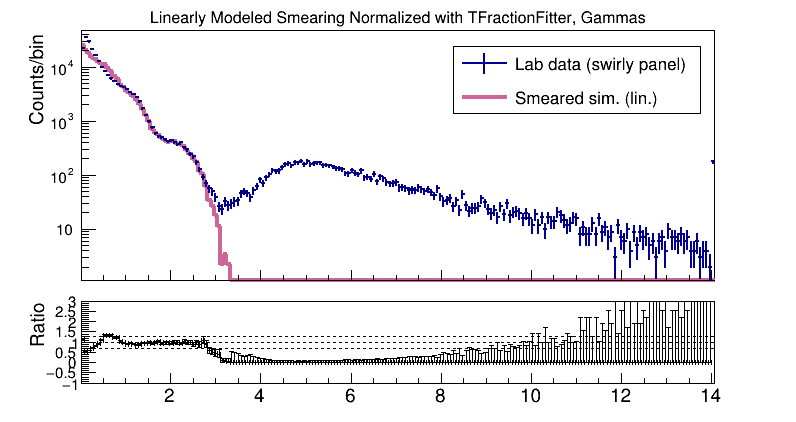

In [9]:
c2 = TCanvas('c2','',800,450)

# c2.cd()
# c2.SetLogy()

# gStyle.SetPalette(kRust)
gPad.SetLogy()
gStyle.SetStatFontSize(.08)
gStyle.SetTitleFontSize(0.085)
gStyle.SetStatW(0.4)
gStyle.SetPalette(kBird)

h_dat.Draw("plc pmc hist")
tots.SetTitle("Linearly Modeled Smearing Normalized with TFractionFitter, Gammas")
    
# tot.SetMarkerColor(kGray+1)
# tot.SetLineColor(kGray+1)
tots.SetLineWidth(4)
tots.SetLineColor(kTeal - 1)
tots.Draw("hist same")
tots.SetAxisRange(0.01, 14, "X")
h_dat.SetAxisRange(0.01, 14, "X")
tots.SetLineColor(kPink+2)
h_dat.SetLineWidth(2)

c2.Clear()

rp2 = TRatioPlot(tots,h_dat)
rp2.Draw()

rp2.GetLowerRefYaxis().SetTitle("Ratio")
rp2.GetUpperRefYaxis().SetTitle("Counts/bin")
rp2.GetUpperRefYaxis().SetTitleOffset(0.7)
rp2.GetLowerRefYaxis().SetTitleOffset(0.7)
rp2.GetLowerRefYaxis().SetRangeUser(-1,3)

rp2.GetLowerRefYaxis().SetLabelSize(.04)
rp2.GetLowerRefYaxis().SetTitleSize(.05)
rp2.GetUpperRefYaxis().SetLabelSize(.04)
rp2.GetUpperRefYaxis().SetTitleSize(.05)
rp2.GetLowerRefXaxis().SetLabelSize(.05)
rp2.GetLowerRefXaxis().SetTitleSize(.045)

# rp1.GetUpperPad().SetGrid()

chi2_2 = " #chi^{2}/ndf = " + str(round(tots.Chi2Test(h_dat, "CHI2/NDF"), 8)) + " "

legend = TLegend(0.57,0.73,0.88,0.89)
legend.AddEntry(h_dat,"Lab data (swirly panel)","le")
legend.AddEntry(tots,"Smeared sim. (lin.)","l")
legend.Draw()

# title = TPaveText(0.14, 0.395, 0.47, 0.50, "NDC")
# title.AddText(chi2_2)
# title.SetMargin(0.05)
# title.SetBorderSize(1)
# title.SetFillColor(0)
# title.Draw()

c2.Draw()

# c2.SaveAs("NormV1_LinSmearNORMALIZED_v3.png")